In [1]:
import qiskit

In [2]:
#Librerie utili allo scopo
from math import sqrt, pi
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit import IBMQ, Aer, transpile, assemble
from qiskit.visualization import plot_histogram, plot_bloch_multivector, array_to_latex
from qiskit.extensions import Initialize
from qiskit.ignis.verification import marginal_counts
from qiskit.quantum_info import random_statevector
from qiskit import execute

C:\Users\mirco\AppData\Local\Temp/ipykernel_672/612666371.py:8: DeprecationWarning: The qiskit.ignis package is deprecated and has been supersceded by the qiskit-experiments project. Refer to the migration guide: https://github.com/Qiskit/qiskit-ignis#migration-guide on how to migrate to the new project.
  from qiskit.ignis.verification import marginal_counts


In [3]:
#Creazione del circuito per il teletrasporto
qc = QuantumRegister(3) #Tre qubit
crz = ClassicalRegister(1) #Primo bit classico
crx = ClassicalRegister(1) #Terzo bit classico
final = ClassicalRegister(1) #Bit finale classico -> conterrà 0 se il teletrasporto funziona
teleportation_circuit = QuantumCircuit(qc, crz, crx, final) #Compongo il circuito
#Circuito iniziale
teleportation_circuit.draw()

q0_0: 
      
q0_1: 
      
q0_2: 
      
c0: 1/
      
c1: 1/
      
c2: 1/

In [4]:
initial_state = [sqrt(0.9), sqrt(0.1)]  #AlphaQuadro=0.9 BetaQuadro=0.1
#initial_state = [sqrt(0.3), sqrt(0.7)]  #AlphaQuadro=0.3 BetaQuadro=0.7
init_state = Initialize(initial_state) #Uso questa funzione per poter dopo applicare un disentangler
init_state.label = "init"

teleportation_circuit.append(init_state, [0]) #Inizializzo primo bit con le probabilità sopra descritte
teleportation_circuit.barrier()
#Vediamo come siamo messi
teleportation_circuit.draw()

┌───────────────────────┐ ░ 
q0_0: ┤ init(0.94868,0.31623) ├─░─
      └───────────────────────┘ ░ 
q0_1: ──────────────────────────░─
                                ░ 
q0_2: ──────────────────────────░─
                                ░ 
c0: 1/════════════════════════════
                                  
c1: 1/════════════════════════════
                                  
c2: 1/════════════════════════════

In [5]:
#PRIMO STEP -> creo bit entangled
#Creo bit entangled di A e B
teleportation_circuit.h(1) #Hademard sul secondo qubit generale
teleportation_circuit.cx(1,2) #CNOT  su terzo bit  (2) controllato dal secondo (1)
#Vediamo come siamo messi
teleportation_circuit.draw()

┌───────────────────────┐ ░           
q0_0: ┤ init(0.94868,0.31623) ├─░───────────
      └───────────────────────┘ ░ ┌───┐     
q0_1: ──────────────────────────░─┤ H ├──■──
                                ░ └───┘┌─┴─┐
q0_2: ──────────────────────────░──────┤ X ├
                                ░      └───┘
c0: 1/══════════════════════════════════════
                                            
c1: 1/══════════════════════════════════════
                                            
c2: 1/══════════════════════════════════════

In [6]:
#SECONDO STEP -> "collego" il messaggio al qubit entangled
teleportation_circuit.barrier() #Barriera
teleportation_circuit.cx(0, 1) #CNOT su secondo bit (1) controllato dal primo bit (0)
teleportation_circuit.h(0) #Hademard sul messaggio
#Circuito aggiornato
teleportation_circuit.draw()

┌───────────────────────┐ ░            ░      ┌───┐
q0_0: ┤ init(0.94868,0.31623) ├─░────────────░───■──┤ H ├
      └───────────────────────┘ ░ ┌───┐      ░ ┌─┴─┐└───┘
q0_1: ──────────────────────────░─┤ H ├──■───░─┤ X ├─────
                                ░ └───┘┌─┴─┐ ░ └───┘     
q0_2: ──────────────────────────░──────┤ X ├─░───────────
                                ░      └───┘ ░           
c0: 1/═══════════════════════════════════════════════════
                                                         
c1: 1/═══════════════════════════════════════════════════
                                                         
c2: 1/═══════════════════════════════════════════════════

In [7]:
#TERZO STEP -> misura di A
#A effetuua una misura sui due qubit che ha, il risultato sarà nei registri classici
teleportation_circuit.barrier()
teleportation_circuit.measure(0,crz) #Misura del primo qubit nel registro classico crz
teleportation_circuit.measure(1,crx) #Misura del secondo qubit nel registro classico crx
#Circuito aggiornato
teleportation_circuit.draw()

┌───────────────────────┐ ░            ░      ┌───┐ ░ ┌─┐   
q0_0: ┤ init(0.94868,0.31623) ├─░────────────░───■──┤ H ├─░─┤M├───
      └───────────────────────┘ ░ ┌───┐      ░ ┌─┴─┐└───┘ ░ └╥┘┌─┐
q0_1: ──────────────────────────░─┤ H ├──■───░─┤ X ├──────░──╫─┤M├
                                ░ └───┘┌─┴─┐ ░ └───┘      ░  ║ └╥┘
q0_2: ──────────────────────────░──────┤ X ├─░────────────░──╫──╫─
                                ░      └───┘ ░            ░  ║  ║ 
c0: 1/═══════════════════════════════════════════════════════╩══╬═
                                                             0  ║ 
                                                                ║ 
c1: 1/══════════════════════════════════════════════════════════╩═
                                                                0 
                                                                  
c2: 1/════════════════════════════════════════════════════════════

In [8]:
#ULTIMO STEP -> porta correttiva applicata da B
# 00 -> Niente
# 10 -> Z
# 01 -> X
# 11 -> XZ
teleportation_circuit.x(2).c_if(crx, 1) #Applico porta di correzione X se ho 1 nel registro
teleportation_circuit.z(2).c_if(crz, 1) #Applico porta di correzione Z se ho 1 nel registro
#Circuito aggiornato
teleportation_circuit.draw()

┌───────────────────────┐ ░            ░      ┌───┐ ░ ┌─┐          »
q0_0: ┤ init(0.94868,0.31623) ├─░────────────░───■──┤ H ├─░─┤M├──────────»
      └───────────────────────┘ ░ ┌───┐      ░ ┌─┴─┐└───┘ ░ └╥┘┌─┐       »
q0_1: ──────────────────────────░─┤ H ├──■───░─┤ X ├──────░──╫─┤M├───────»
                                ░ └───┘┌─┴─┐ ░ └───┘      ░  ║ └╥┘ ┌───┐ »
q0_2: ──────────────────────────░──────┤ X ├─░────────────░──╫──╫──┤ X ├─»
                                ░      └───┘ ░            ░  ║  ║  └─╥─┘ »
c0: 1/═══════════════════════════════════════════════════════╩══╬════╬═══»
                                                             0  ║ ┌──╨──┐»
c1: 1/══════════════════════════════════════════════════════════╩═╡ 0x1 ╞»
                                                                0 └─────┘»
c2: 1/═══════════════════════════════════════════════════════════════════»
                                                                         »
«             
«q0_0: ───────
«             
«q0_1: ───────
«       ┌───┐ 
«q0_2: ─┤ Z ├─
«       └─╥─┘ 
«      ┌──╨──┐
«c0: 1/╡ 0x1 ╞
«      └─────┘
«c1: 1/═══════
«             
«c2: 1/═══════
«

In [9]:
#Disentangler
inverse_init_state = init_state.gates_to_uncompute() #Porta che mi dovrebbe dare sempre 0
teleportation_circuit.append(inverse_init_state, [2]) #Applico trasformazione inversa
#Circuito aggiornato
teleportation_circuit.draw()

┌───────────────────────┐ ░            ░      ┌───┐ ░ ┌─┐          »
q0_0: ┤ init(0.94868,0.31623) ├─░────────────░───■──┤ H ├─░─┤M├──────────»
      └───────────────────────┘ ░ ┌───┐      ░ ┌─┴─┐└───┘ ░ └╥┘┌─┐       »
q0_1: ──────────────────────────░─┤ H ├──■───░─┤ X ├──────░──╫─┤M├───────»
                                ░ └───┘┌─┴─┐ ░ └───┘      ░  ║ └╥┘ ┌───┐ »
q0_2: ──────────────────────────░──────┤ X ├─░────────────░──╫──╫──┤ X ├─»
                                ░      └───┘ ░            ░  ║  ║  └─╥─┘ »
c0: 1/═══════════════════════════════════════════════════════╩══╬════╬═══»
                                                             0  ║ ┌──╨──┐»
c1: 1/══════════════════════════════════════════════════════════╩═╡ 0x1 ╞»
                                                                0 └─────┘»
c2: 1/═══════════════════════════════════════════════════════════════════»
                                                                         »
«                             
«q0_0: ───────────────────────
«                             
«q0_1: ───────────────────────
«       ┌───┐ ┌──────────────┐
«q0_2: ─┤ Z ├─┤ disentangler ├
«       └─╥─┘ └──────────────┘
«      ┌──╨──┐                
«c0: 1/╡ 0x1 ╞════════════════
«      └─────┘                
«c1: 1/═══════════════════════
«                             
«c2: 1/═══════════════════════
«

In [10]:
#Misura finale, se tutto è andato bene dovrei avere 0 nell'ultimo bit
teleportation_circuit.measure(2,2)
teleportation_circuit.draw()

┌───────────────────────┐ ░            ░      ┌───┐ ░ ┌─┐          »
q0_0: ┤ init(0.94868,0.31623) ├─░────────────░───■──┤ H ├─░─┤M├──────────»
      └───────────────────────┘ ░ ┌───┐      ░ ┌─┴─┐└───┘ ░ └╥┘┌─┐       »
q0_1: ──────────────────────────░─┤ H ├──■───░─┤ X ├──────░──╫─┤M├───────»
                                ░ └───┘┌─┴─┐ ░ └───┘      ░  ║ └╥┘ ┌───┐ »
q0_2: ──────────────────────────░──────┤ X ├─░────────────░──╫──╫──┤ X ├─»
                                ░      └───┘ ░            ░  ║  ║  └─╥─┘ »
c0: 1/═══════════════════════════════════════════════════════╩══╬════╬═══»
                                                             0  ║ ┌──╨──┐»
c1: 1/══════════════════════════════════════════════════════════╩═╡ 0x1 ╞»
                                                                0 └─────┘»
c2: 1/═══════════════════════════════════════════════════════════════════»
                                                                         »
«                                
«q0_0: ──────────────────────────
«                                
«q0_1: ──────────────────────────
«       ┌───┐ ┌──────────────┐┌─┐
«q0_2: ─┤ Z ├─┤ disentangler ├┤M├
«       └─╥─┘ └──────────────┘└╥┘
«      ┌──╨──┐                 ║ 
«c0: 1/╡ 0x1 ╞═════════════════╬═
«      └─────┘                 ║ 
«c1: 1/════════════════════════╬═
«                              ║ 
«c2: 1/════════════════════════╩═
«                              0

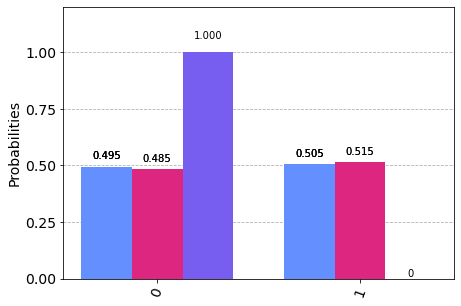

In [11]:
#SIMULAZIONE ESPERIMENTO
sim = Aer.get_backend('qasm_simulator')
t_qc = transpile(teleportation_circuit, sim)
t_qc.save_statevector()
counts = sim.run(t_qc).result().get_counts()
qubit_counts = [marginal_counts(counts, [qubit]) for qubit in range(3)]
plot_histogram(qubit_counts)